This note book is for the use of CSI4106 course project, by group 38.
It uses cnn to train rock types and predict results.

# Import Library

In [52]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from os import listdir
from os.path import isfile, join
from IPython.display import display
from PIL import Image





# Define Constants

In [53]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [54]:
rootdir = './input/rockall'
filenames = os.listdir(rootdir)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'crimp':
        categories.append(0)
    elif category == 'jug':
        catefories.append(1)
    elif category == 'pinch':
        catefories.append(2)
    elif category == 'pocket':
        catefories.append(3)
    elif category == 'sloper':
        catefories.append(4)
    else:
        categories.append(5)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [55]:
df.head()

,filename,category
0,volume33.jpg,5
1,crimp104.jpeg,5
2,volume123.jpg,5
3,pocket126.jpg,5
4,pocket42.jpeg,5


In [56]:
df.tail()

,filename,category
763,volume106.png,5
764,jug70.jpeg,5
765,pocket82.jpeg,5
766,volume112.png,5
767,volume17.jpeg,5


### See Total In count

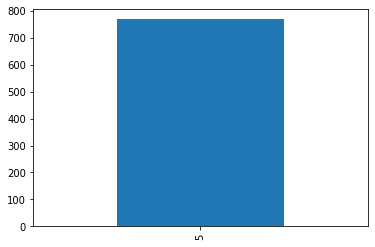

In [57]:
df['category'].value_counts().plot.bar()

# Build Model


* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) # 6 because we have 6 types of rocks

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)       

# Callbacks

In [59]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [60]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [61]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [62]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 


In [63]:
df["category"] = df["category"].replace({0: 'crimp', 1: 'jug', 2: 'pinch', 3: 'pocket', 4: 'sloper', 5: 'volume'}) 

In [64]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

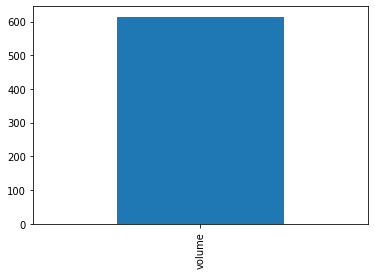

In [65]:
train_df['category'].value_counts().plot.bar()

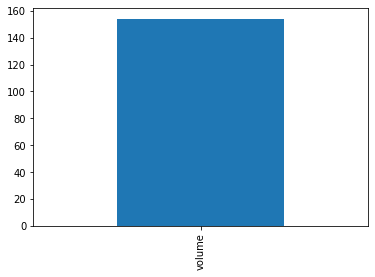

In [66]:
validate_df['category'].value_counts().plot.bar()

In [67]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [68]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    rootdir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 614 validated image filenames belonging to 1 classes.


### Validation Generator

In [69]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    rootdir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 154 validated image filenames belonging to 1 classes.


# See how our generator work

In [70]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    rootdir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


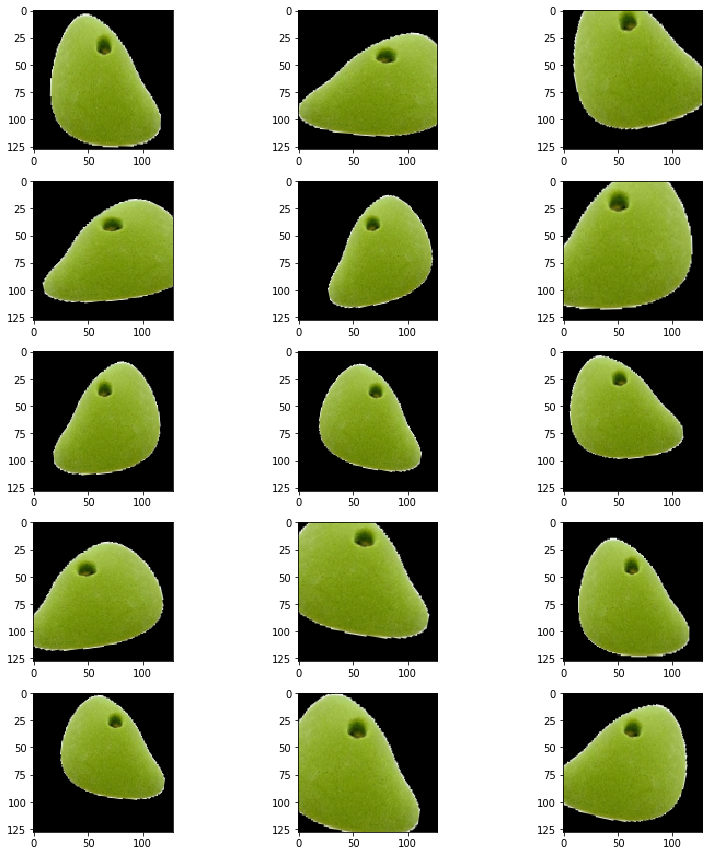

In [71]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [72]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


ValueError: Error when checking target: expected dense_6 to have shape (6,) but got array with shape (1,)

# Save Model

In [ ]:
model.save_weights("model.h5")

# Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [ ]:
test_filenames = os.listdir(rootdir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    rootdir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

map back to types

In [ ]:
test_df['category'] = test_df['category'].replace({'volume': 5, 'sloper': 4, 'pocket': 3, 'pinch': 2, 'jug': 1, 'crimp': 0 })

### Virtaulize Result

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(rootdir+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)